In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white
from matplotlib.cbook import boxplot_stats

In [2]:
# Load data from other notebook
gdf = pd.read_pickle('data/geodata.pkl')
df = pd.DataFrame(gdf)

In [3]:
df.columns

Index(['index', 'id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'geometry',
       'dist_2_downtown'],
      dtype='object')

In [4]:
df = df.fillna(0).replace('?',0).replace('"?',0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20250 entries, 0 to 20249
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            20250 non-null  int64  
 1   id               20250 non-null  int64  
 2   date             20250 non-null  object 
 3   price            20250 non-null  int64  
 4   bedrooms         20250 non-null  int64  
 5   bathrooms        20250 non-null  float64
 6   sqft_living      20250 non-null  int64  
 7   sqft_lot         20250 non-null  int64  
 8   floors           20250 non-null  float64
 9   waterfront       20250 non-null  float64
 10  view             20250 non-null  float64
 11  condition        20250 non-null  int64  
 12  grade            20250 non-null  int64  
 13  sqft_above       20250 non-null  object 
 14  sqft_basement    20250 non-null  object 
 15  yr_built         20250 non-null  int64  
 16  yr_renovated     20250 non-null  float64
 17  zipcode     

In [6]:
# Clean up the data to change strings to integers and delete unnecessary columns
df['sqft_above'] = df['sqft_above'].astype(int)
df['sqft_basement'] = df['sqft_basement'].astype(int)
df = df.drop(columns=['index', 'id', 'geometry'])
df['yr_renovated'] = df['yr_renovated'].astype(int)

In [7]:
# Converting date to datetime
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.month

In [8]:
df_b4_dummies = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20250 entries, 0 to 20249
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             20250 non-null  int64  
 1   price            20250 non-null  int64  
 2   bedrooms         20250 non-null  int64  
 3   bathrooms        20250 non-null  float64
 4   sqft_living      20250 non-null  int64  
 5   sqft_lot         20250 non-null  int64  
 6   floors           20250 non-null  float64
 7   waterfront       20250 non-null  float64
 8   view             20250 non-null  float64
 9   condition        20250 non-null  int64  
 10  grade            20250 non-null  int64  
 11  sqft_above       20250 non-null  int32  
 12  sqft_basement    20250 non-null  int32  
 13  yr_built         20250 non-null  int64  
 14  yr_renovated     20250 non-null  int32  
 15  zipcode          20250 non-null  int64  
 16  lat              20250 non-null  float64
 17  long        

In [9]:
df_b4_dummies.head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,dist_2_downtown
0,10,221900,3,1.00,1180,5650,1.0,0.0,0.0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,11.005
1,12,538000,3,2.25,2570,7242,2.0,0.0,0.0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,11.961
2,2,180000,2,1.00,770,10000,1.0,0.0,0.0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,15.348


In [10]:
plt.style.use('ggplot')

[['price', 105000, 1020000], ['bedrooms', 2, 5], ['bathrooms', 0.5, 4.0], ['sqft_living', 370, 3950], ['sqft_lot', 520, 18205], ['floors', 1.0, 3.5], ['condition', 2, 5], ['sqft_above', 0, 3470], ['sqft_basement', 0, 1250], ['lat', 47.1559, 47.7776], ['long', -122.51899999999999, -121.815], ['sqft_living15', 399, 3470], ['sqft_lot15', 651, 17085], ['dist_2_downtown', 1.065, 45.357], ['zipcode', 98001, 98199]]


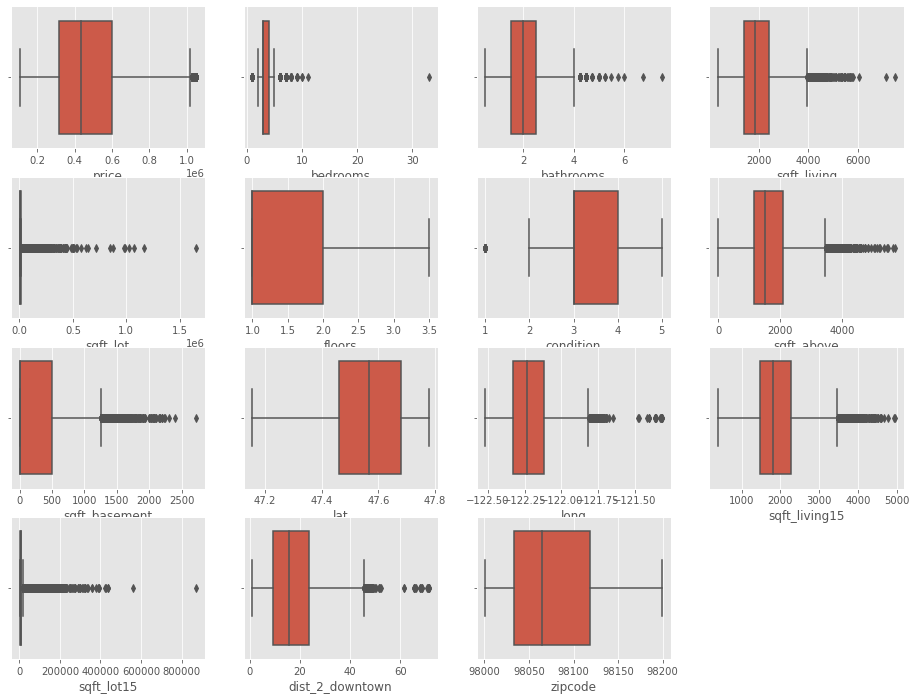

In [11]:
# Remove outliers first
cols_to_limit = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 
                 'sqft_lot', 'floors', 'condition', 'sqft_above',
                 'sqft_basement', 'lat', 'long', 'sqft_living15', 
                 'sqft_lot15', 'dist_2_downtown', 'zipcode']

plot_no = 1
plt.figure(figsize=(16,12))
feat_ranges = []
for col in cols_to_limit:
    plt.subplot(4, 4, plot_no)
    sns.boxplot(x=df_b4_dummies[col])
    feat_ranges.append([col, boxplot_stats(df_b4_dummies[col]).pop(0)['whislo'], 
                   boxplot_stats(df_b4_dummies[col]).pop(0)['whishi']])
    plot_no += 1

print(feat_ranges)

In [12]:
# Remove rows with outliers from dataframe
for feat in feat_ranges:
    df_b4_dummies = df_b4_dummies[(df_b4_dummies[feat[0]] >= feat[1]) 
                                  & (df_b4_dummies[feat[0]] <= feat[2])]
df_b4_dummies

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,dist_2_downtown
0,10,221900,3,1.00,1180,5650,1.0,0.0,0.0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,11.005
1,12,538000,3,2.25,2570,7242,2.0,0.0,0.0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,11.961
2,2,180000,2,1.00,770,10000,1.0,0.0,0.0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,15.348
3,12,604000,4,3.00,1960,5000,1.0,0.0,0.0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,9.536
4,2,510000,3,2.00,1680,8080,1.0,0.0,0.0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,20.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20245,5,360000,3,2.50,1530,1131,3.0,0.0,0.0,3,...,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,9.716
20246,2,400000,4,2.50,2310,5813,2.0,0.0,0.0,3,...,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,9.852
20247,6,402101,2,0.75,1020,1350,2.0,0.0,0.0,3,...,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,2.679
20248,1,400000,3,2.50,1600,2388,2.0,0.0,0.0,3,...,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,19.729


['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'dist_2_downtown']


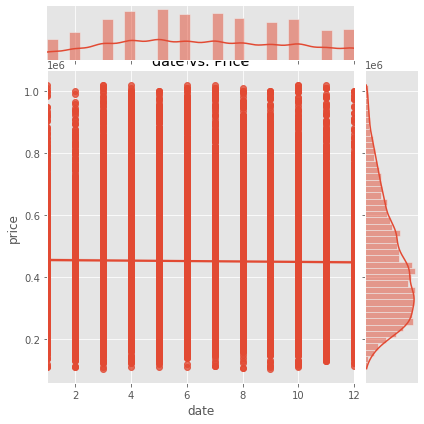

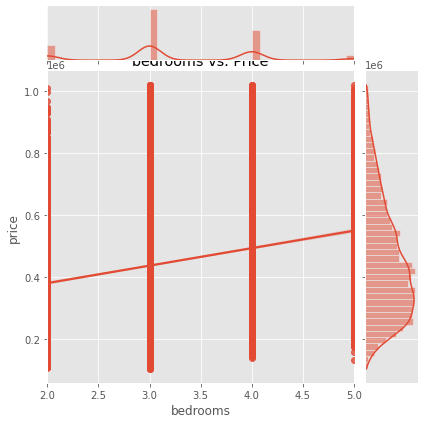

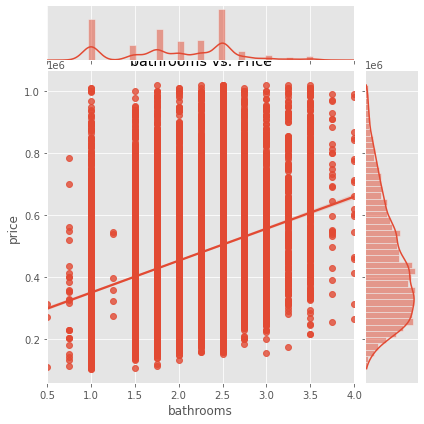

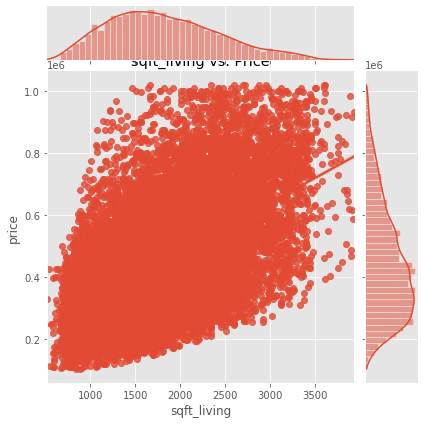

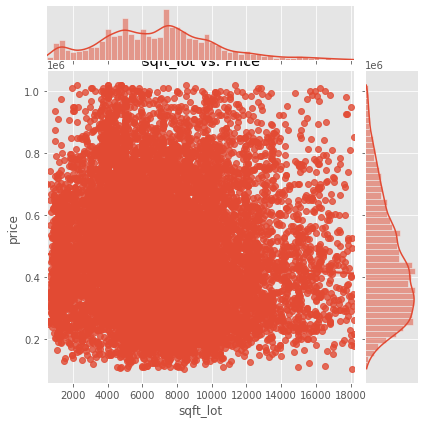

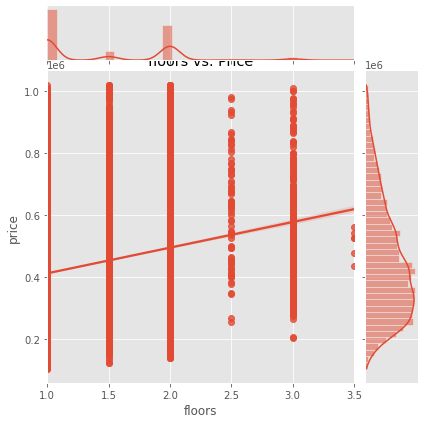

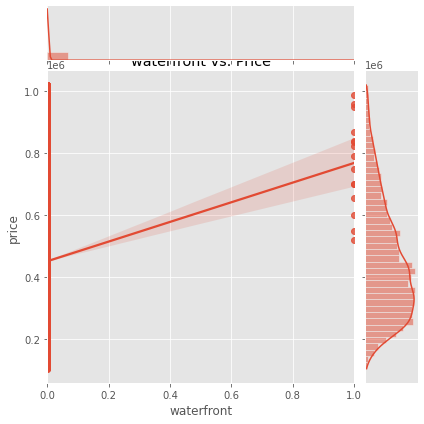

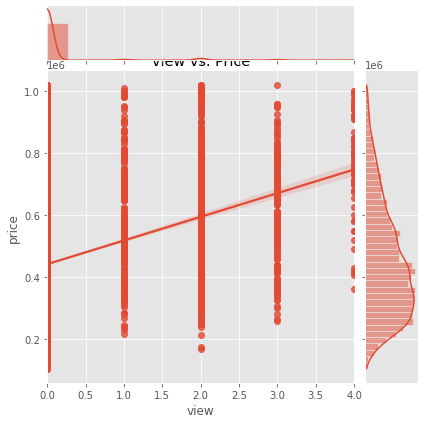

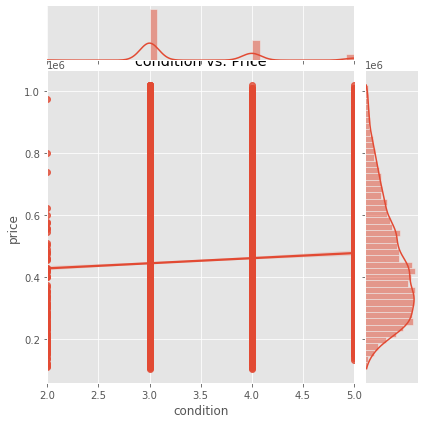

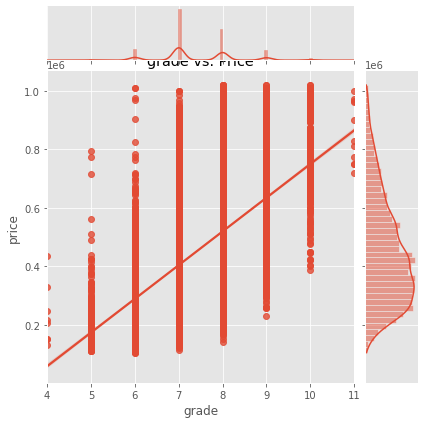

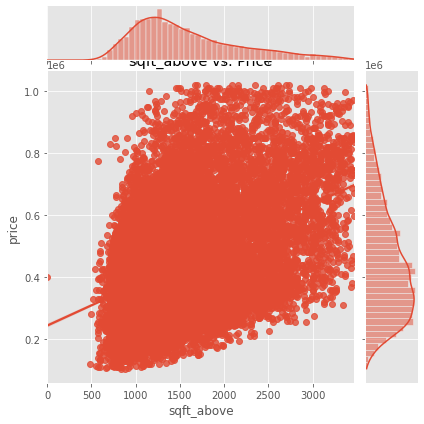

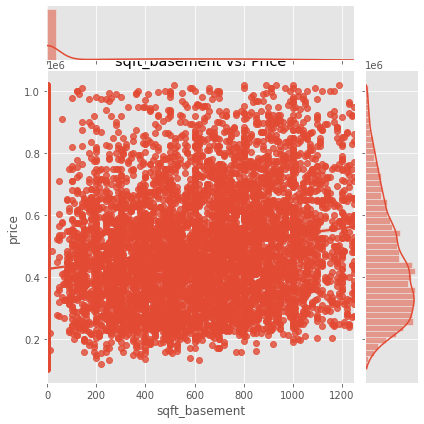

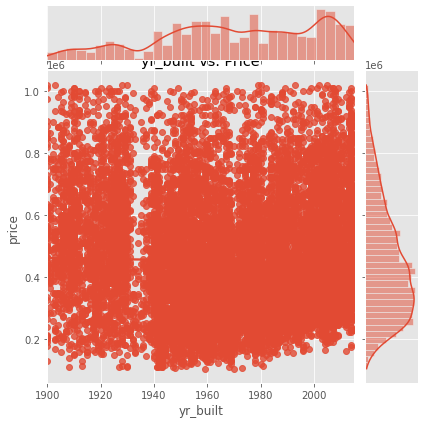

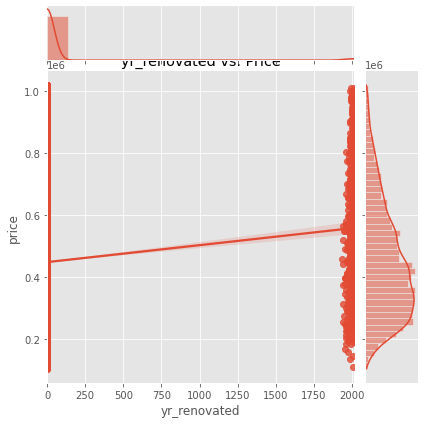

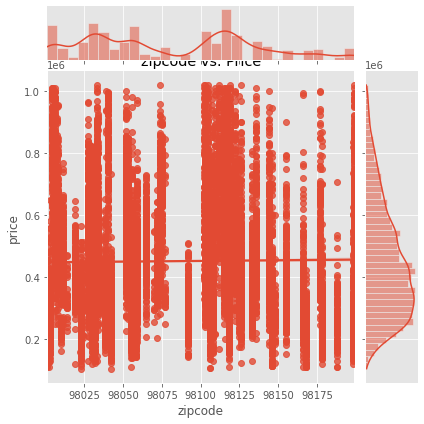

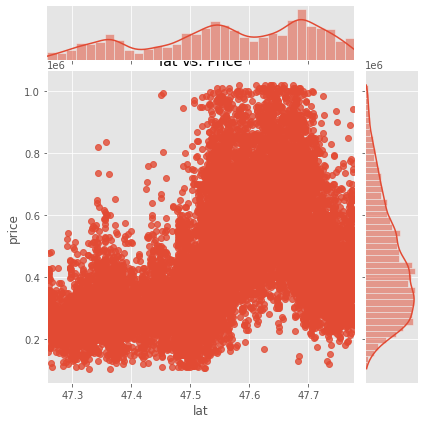

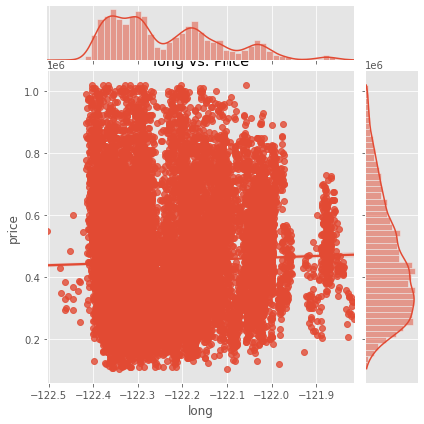

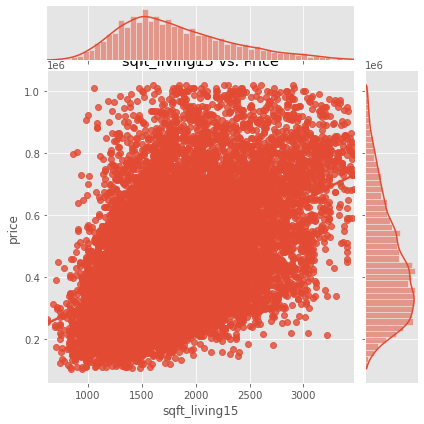

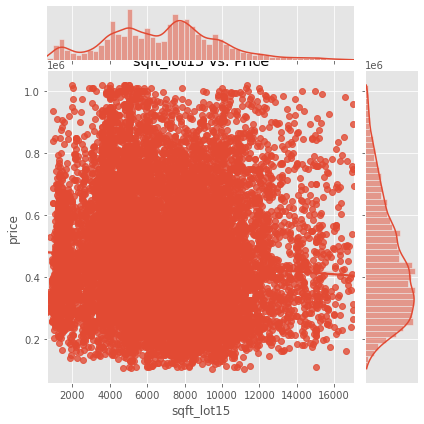

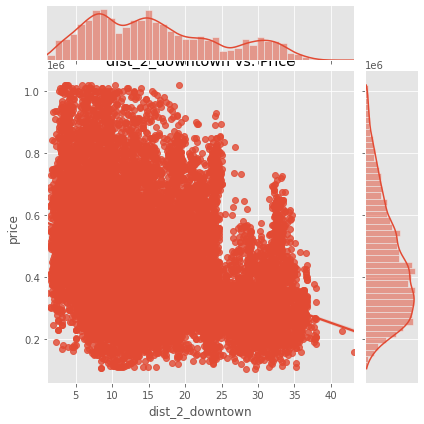

In [13]:
# look at features vs. price to get a sense what the influencers are
cols = list(df_b4_dummies.columns)
cols.remove('price')
print(cols)
for col in cols:
    sns.jointplot(x=col, y='price', data=df_b4_dummies, kind='reg')
    title = col+' vs. Price'
    plt.title(title)

<AxesSubplot:>

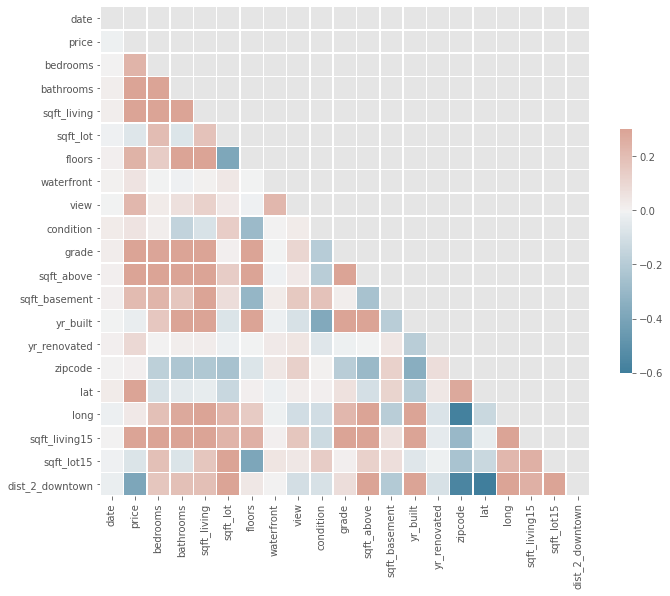

In [14]:
# Create a heatmap to identify any features with obvious multicollinearity 

corr = df_b4_dummies.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [15]:
# Check for Multicollinearity
cols = list(df_b4_dummies.columns)
cols.remove('price')
X = df_b4_dummies[cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(cols, vif))

[('date', 5.427906964820898),
 ('bedrooms', 31.625437529691265),
 ('bathrooms', 29.476658559136723),
 ('sqft_living', 904.6142468883447),
 ('sqft_lot', 24.960479391174058),
 ('floors', 22.728808628566043),
 ('waterfront', 1.0584945221909234),
 ('view', 1.2160235503031127),
 ('condition', 36.579883403067946),
 ('grade', 172.59117505076833),
 ('sqft_above', 699.4802751163973),
 ('sqft_basement', 41.54200617688805),
 ('yr_built', 12137.995857422487),
 ('yr_renovated', 1.1323170181402764),
 ('zipcode', 2522913.612925252),
 ('lat', 201501.25243492762),
 ('long', 1989633.5705918972),
 ('sqft_living15', 35.12230238770869),
 ('sqft_lot15', 29.369390536629286),
 ('dist_2_downtown', 11.12353795197118)]

In [16]:
# Drop location-related columns, drop zipcode and latitude
df_b4_dummies = df_b4_dummies.drop(columns=['zipcode'])

<AxesSubplot:>

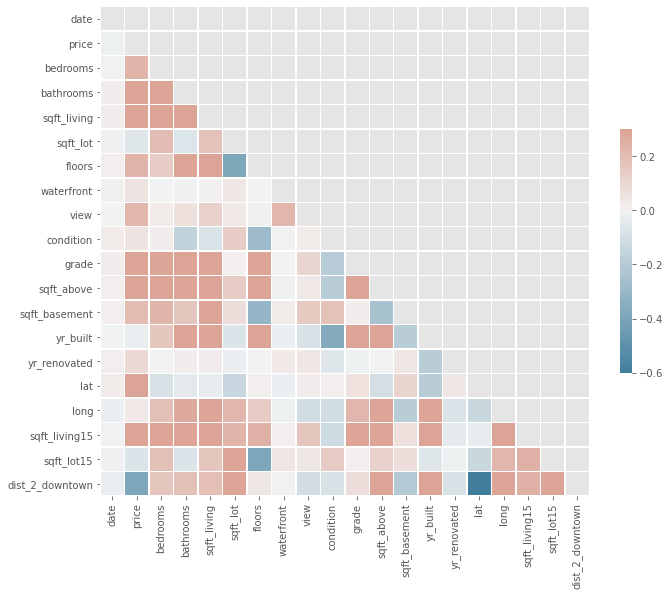

In [17]:
# Check heatmap again
corr = df_b4_dummies.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
df = df_b4_dummies.copy()

In [19]:
df.describe()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,dist_2_downtown
count,16363.000000,1.636300e+04,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000
mean,6.562366,4.517670e+05,3.255638,1.983285,1827.464585,6971.636741,1.473630,0.000917,0.125527,3.410438,7.412883,1591.236693,230.948665,1969.898735,54.517387,47.562715,-122.235835,1814.254293,6869.913952,15.993219
std,3.123924,1.860190e+05,0.774378,0.659509,620.560299,3323.913730,0.546621,0.030264,0.535054,0.641413,0.899774,606.013212,348.763516,29.919001,325.332462,0.136589,0.123228,517.587980,2982.984637,8.821366
min,1.000000,1.050000e+05,2.000000,0.500000,520.000000,520.000000,1.000000,0.000000,0.000000,2.000000,4.000000,0.000000,0.000000,1900.000000,0.000000,47.257400,-122.503000,620.000000,651.000000,1.065000
25%,4.000000,3.065000e+05,3.000000,1.500000,1350.000000,4680.500000,1.000000,0.000000,0.000000,3.000000,7.000000,1140.000000,0.000000,1950.000000,0.000000,47.474500,-122.339000,1430.000000,4800.000000,8.676000
50%,6.000000,4.200000e+05,3.000000,2.000000,1760.000000,6984.000000,1.000000,0.000000,0.000000,3.000000,7.000000,1440.000000,0.000000,1971.000000,0.000000,47.571000,-122.273000,1720.000000,7075.000000,14.656000
75%,9.000000,5.650000e+05,4.000000,2.500000,2240.000000,8924.500000,2.000000,0.000000,0.000000,4.000000,8.000000,1930.000000,460.000000,1997.000000,0.000000,47.682100,-122.160000,2130.000000,8660.500000,22.015000
max,12.000000,1.020000e+06,5.000000,4.000000,3940.000000,18205.000000,3.500000,1.000000,4.000000,5.000000,11.000000,3470.000000,1250.000000,2015.000000,2015.000000,47.777600,-121.815000,3470.000000,17060.000000,43.205000


In [20]:
# Marking Categories
df.waterfront = df.waterfront.astype('category')
df.view = df.view.astype('category')
df.condition = df.condition.astype('category')
df.grade = df.grade.astype('category')
df.bedrooms = df.bedrooms.astype('category')
df.floors = df.floors.astype('category')
df.bathrooms = df.bathrooms.astype('category')

In [21]:
# Making Dummies
waterfront = pd.get_dummies(df.waterfront, prefix='waterfront', drop_first=True)
view = pd.get_dummies(df.view, prefix='view', drop_first=True)
condition = pd.get_dummies(df.condition, prefix='condition', drop_first=True)
grade = pd.get_dummies(df.grade, prefix='grade', drop_first=True)
bedrooms = pd.get_dummies(df.bedrooms, prefix='bedrooms', drop_first=True)
floors = pd.get_dummies(df.floors, prefix='floors', drop_first=True)
bathrooms = pd.get_dummies(df.bathrooms, prefix='bathrooms', drop_first=True)

# Take care of dates
mos = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df['date'] = [mos[mo-1] for mo in df['date']]
df['date'] = df['date'].astype(str)
date = pd.get_dummies(df.date, prefix='date', drop_first=True)

# Adding dummies to the dataset and removing original features
df = df.join([waterfront, view, condition, grade, bedrooms, floors, bathrooms, date])
df.drop(['waterfront','view','condition','grade','bedrooms', 'floors', 'bathrooms', 'date'], axis=1, inplace=True)
df.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,...,date_Dec,date_Feb,date_Jan,date_Jul,date_Jun,date_Mar,date_May,date_Nov,date_Oct,date_Sep
0,221900,1180,5650,1180,0,1955,0,47.5112,-122.257,1340,...,0,0,0,0,0,0,0,0,1,0
1,538000,2570,7242,2170,400,1951,1991,47.7210,-122.319,1690,...,1,0,0,0,0,0,0,0,0,0
2,180000,770,10000,770,0,1933,0,47.7379,-122.233,2720,...,0,1,0,0,0,0,0,0,0,0
3,604000,1960,5000,1050,910,1965,0,47.5208,-122.393,1360,...,1,0,0,0,0,0,0,0,0,0
4,510000,1680,8080,1680,0,1987,0,47.6168,-122.045,1800,...,0,1,0,0,0,0,0,0,0,0


In [22]:
df.columns = df.columns.str.replace(".", "_")
df.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,...,date_Dec,date_Feb,date_Jan,date_Jul,date_Jun,date_Mar,date_May,date_Nov,date_Oct,date_Sep
0,221900,1180,5650,1180,0,1955,0,47.5112,-122.257,1340,...,0,0,0,0,0,0,0,0,1,0
1,538000,2570,7242,2170,400,1951,1991,47.7210,-122.319,1690,...,1,0,0,0,0,0,0,0,0,0
2,180000,770,10000,770,0,1933,0,47.7379,-122.233,2720,...,0,1,0,0,0,0,0,0,0,0
3,604000,1960,5000,1050,910,1965,0,47.5208,-122.393,1360,...,1,0,0,0,0,0,0,0,0,0
4,510000,1680,8080,1680,0,1987,0,47.6168,-122.045,1800,...,0,1,0,0,0,0,0,0,0,0


## 1st Model

In [23]:
# First Model 
outcome = 'price' # dependent variable
x_cols = list(df.columns)
x_cols.remove('price')# independence variables --> everything except price
# Fitting the actual model using OLS
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     716.8
Date:                Sat, 26 Dec 2020   Prob (F-statistic):               0.00
Time:                        19:16:42   Log-Likelihood:            -2.1129e+05
No. Observations:               16363   AIC:                         4.227e+05
Df Residuals:                   16303   BIC:                         4.232e+05
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.732e+07    1.3e+06     13.289      0.000    1.48e+07    1.99e+07
sqft_living        69.1177     12.003      5.758      0.000      45.590      92.645
sqft_lot           -0.1089      0.499     -0.218      0.827      -1.087       0.869
sqft_above         27.4052     11.999      2.284      0.022       3.885      50.925
sqft_basement      -1.2451     11.862     -0.105      0.916     -24.496      22.006
yr_built        -1179.6058     48.138    -24.505      0.000   -1273.962   -1085.250
yr_renovated       20.3160      2.502      8.120      0.000      15.412      25.220
lat              3.071e+05   7733.767     39.712      0.000    2.92e+05    3.22e+05
long             2.409e+05   9124.720     26.397      0.000    2.23e+05    2.59e+05
sqft_living15      49.9025      2.469     20.214      0.000      45.064      54.741
sqft_lot15         -4.4249      0.560     -7.901      0.000      -5.523      -3.327
dist_2_downtown -7629.0980    162.092    -47.066      0.000   -7946.816   -7311.380
waterfront_1_0   2.032e+05   2.91e+04      6.987      0.000    1.46e+05     2.6e+05
view_1_0         6.303e+04   7028.602      8.967      0.000    4.92e+04    7.68e+04
view_2_0         4.999e+04   4437.507     11.266      0.000    4.13e+04    5.87e+04
view_3_0         4.849e+04   7646.855      6.341      0.000    3.35e+04    6.35e+04
view_4_0         1.554e+05   1.41e+04     11.040      0.000    1.28e+05    1.83e+05
condition_3       2.95e+04   9528.093      3.096      0.002    1.08e+04    4.82e+04
condition_4      6.312e+04   9563.179      6.600      0.000    4.44e+04    8.19e+04
condition_5      8.378e+04   9849.156      8.506      0.000    6.45e+04    1.03e+05
grade_5         -1.341e+04    3.7e+04     -0.362      0.717   -8.59e+04    5.91e+04
grade_6          9924.8634   3.63e+04      0.273      0.785   -6.13e+04    8.11e+04
grade_7          7.307e+04   3.63e+04      2.011      0.044    1864.761    1.44e+05
grade_8          1.396e+05   3.64e+04      3.834      0.000    6.82e+04    2.11e+05
grade_9          2.218e+05   3.66e+04      6.065      0.000     1.5e+05    2.94e+05
grade_10         2.802e+05    3.7e+04      7.566      0.000    2.08e+05    3.53e+05
grade_11         3.194e+05   4.73e+04      6.757      0.000    2.27e+05    4.12e+05
bedrooms_3      -1349.4951   2578.404     -0.523      0.601   -6403.450    3704.460
bedrooms_4      -1.109e+04   3135.363     -3.538      0.000   -1.72e+04   -4946.788
bedrooms_5      -2.735e+04   4568.799     -5.986      0.000   -3.63e+04   -1.84e+04
floors_1_5       7788.6738   3208.460      2.428      0.015    1499.741    1.41e+04
floors_2_0      -6187.0589   2953.403     -2.095      0.036    -1.2e+04    -398.066
floors_2_5       1.111e+04   1.15e+04      0.968      0.333   -1.14e+04    3.36e+04
floors_3_0       -676.1106   5582.105     -0.121      0.904

## Model Refinement 1
Normalize and standardize data

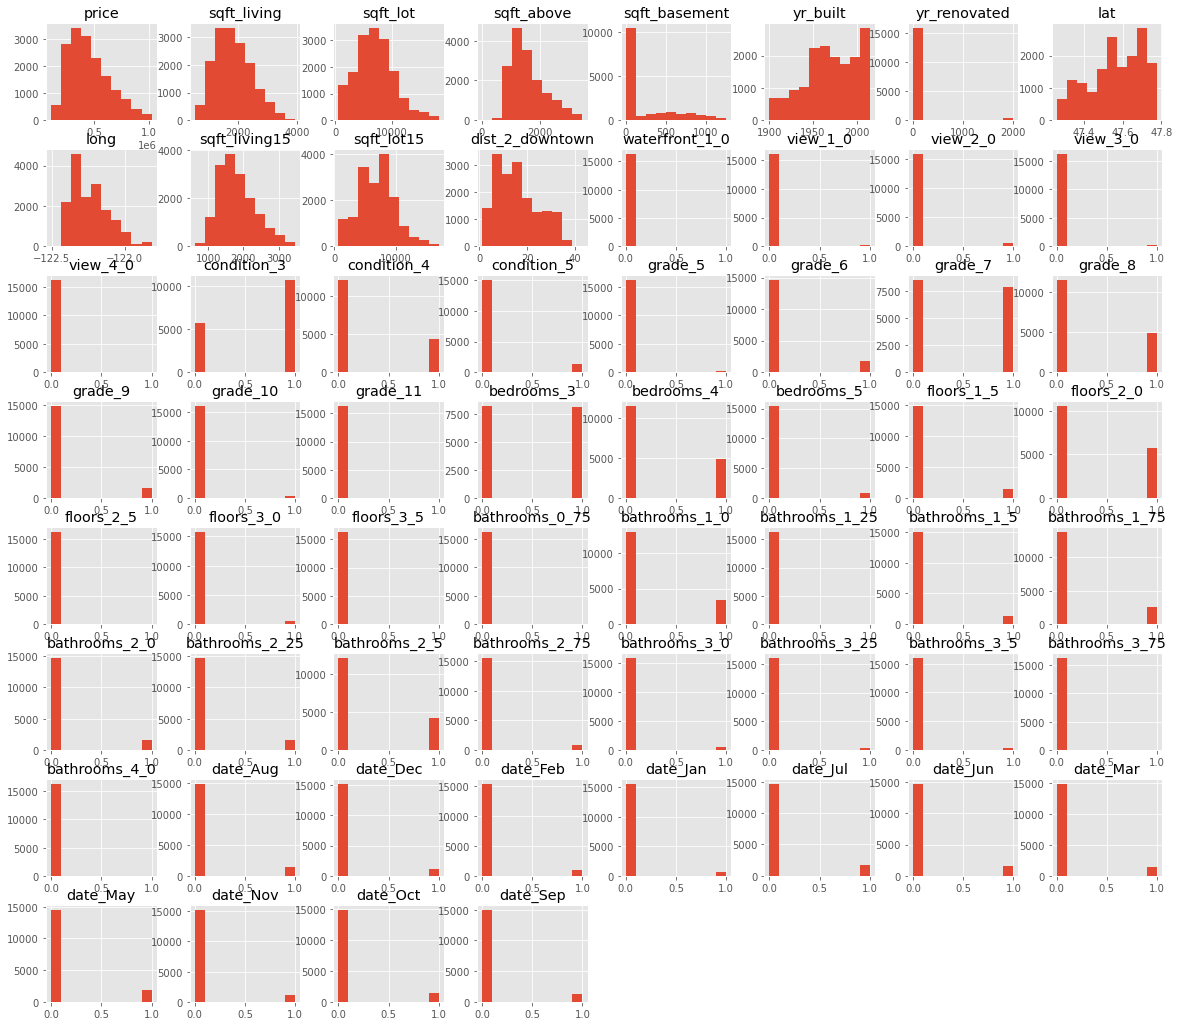

In [24]:
# Create histograms to get a sense of data
df.hist(figsize = (20,18));

In [25]:
df_b4_scale = df.copy() #save unscaled df for later

In [26]:
# Normalize features that we can
feats_4_log = ['price', 'sqft_living', 'lat', 'long',
               'sqft_living15', 'sqft_lot15', 'dist_2_downtown']

df['long'] = df['long']*-1

for feat in feats_4_log:
    df[feat] = np.log(df[feat])

In [27]:
df.describe()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,...,date_Dec,date_Feb,date_Jan,date_Jul,date_Jun,date_Mar,date_May,date_Nov,date_Oct,date_Sep
count,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,...,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000
mean,12.935661,7.450935,6971.636741,1591.236693,230.948665,1969.898735,54.517387,3.862045,4.805952,7.463854,...,0.067836,0.059708,0.045041,0.101326,0.098821,0.088431,0.109699,0.065269,0.087270,0.081953
std,0.418902,0.352283,3323.913730,606.013212,348.763516,29.919001,325.332462,0.002874,0.001008,0.281307,...,0.251472,0.236952,0.207400,0.301769,0.298430,0.283930,0.312523,0.247008,0.282239,0.274302
min,11.561716,6.253829,520.000000,0.000000,0.000000,1900.000000,0.000000,3.855609,4.802504,6.429719,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.632973,7.207860,4680.500000,1140.000000,0.000000,1950.000000,0.000000,3.860193,4.805332,7.265430,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.948010,7.473069,6984.000000,1440.000000,0.000000,1971.000000,0.000000,3.862223,4.806256,7.450080,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13.244581,7.714231,8924.500000,1930.000000,460.000000,1997.000000,0.000000,3.864556,4.806796,7.663877,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,13.835313,8.278936,18205.000000,3470.000000,1250.000000,2015.000000,2015.000000,3.866557,4.808136,8.151910,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
def scale_feat(series):
    return (series - series.min())/(series.max() - series.min())

In [29]:
cols = list(df.columns)

for feat in cols:
    df[feat] = scale_feat(df[feat])
df.describe()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,...,date_Dec,date_Feb,date_Jan,date_Jul,date_Jun,date_Mar,date_May,date_Nov,date_Oct,date_Sep
count,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,...,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000,16363.000000
mean,0.604305,0.591132,0.364808,0.458570,0.184759,0.607815,0.027056,0.587868,0.612257,0.600476,...,0.067836,0.059708,0.045041,0.101326,0.098821,0.088431,0.109699,0.065269,0.087270,0.081953
std,0.184246,0.173958,0.187951,0.174644,0.279011,0.260165,0.161455,0.262479,0.179065,0.163343,...,0.251472,0.236952,0.207400,0.301769,0.298430,0.283930,0.312523,0.247008,0.282239,0.274302
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.471173,0.471102,0.235256,0.328530,0.000000,0.434783,0.000000,0.418671,0.502157,0.485260,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.609736,0.602062,0.365507,0.414986,0.000000,0.617391,0.000000,0.604155,0.666324,0.592478,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.740177,0.721148,0.475233,0.556196,0.368000,0.843478,0.000000,0.817235,0.762139,0.716621,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


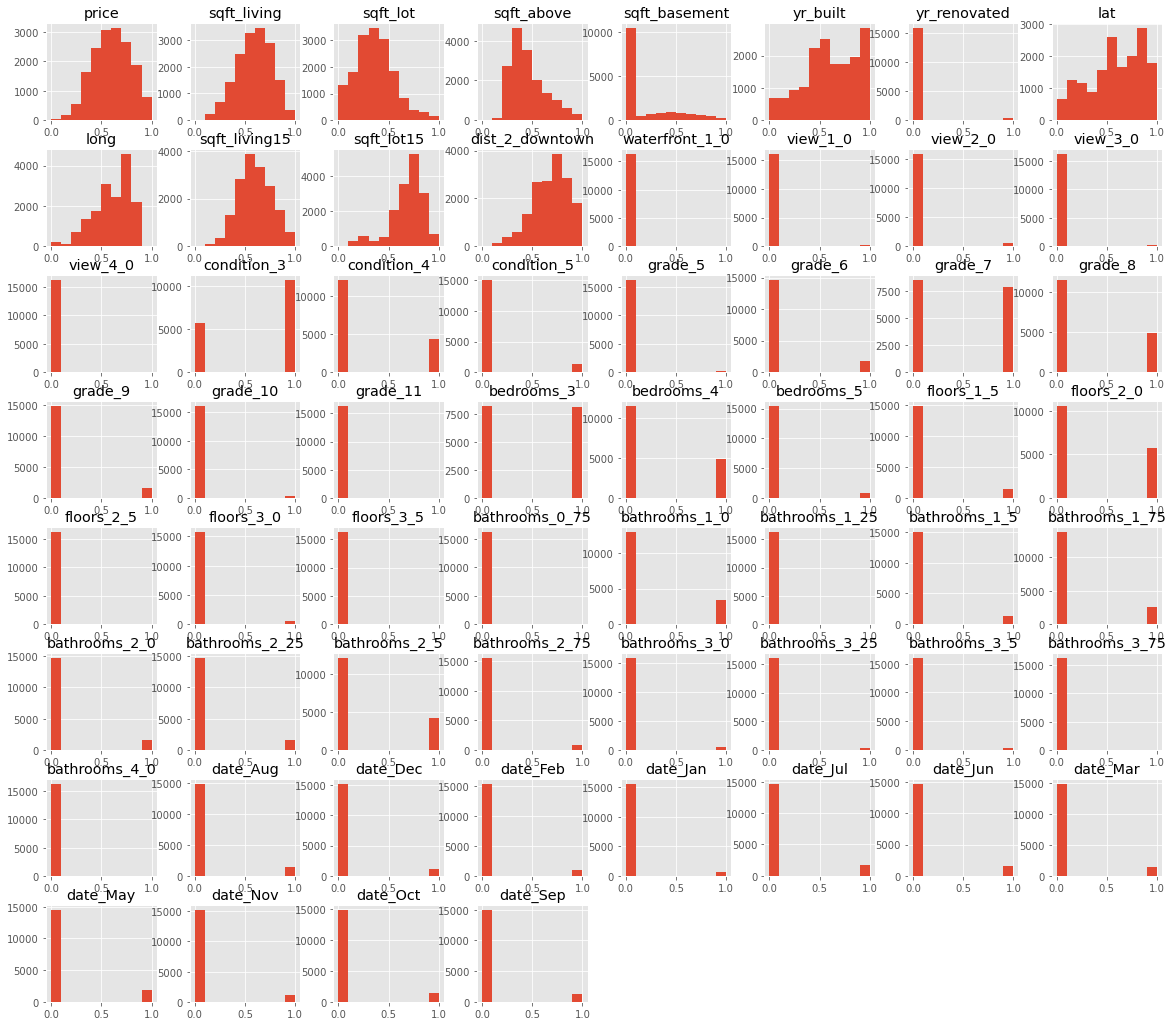

In [30]:
# See what normalization & scaling did
df.hist(figsize = (20,18));

In [31]:
outcome = 'price' # dependent variable

# Fitting the model again
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     894.4
Date:                Sat, 26 Dec 2020   Prob (F-statistic):               0.00
Time:                        19:17:04   Log-Likelihood:                 16273.
No. Observations:               16363   AIC:                        -3.243e+04
Df Residuals:                   16303   BIC:                        -3.196e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3467      0.063      5.527      0.000       0.224       0.470
sqft_living         0.2283      0.022     10.368      0.000       0.185       0.272
sqft_lot           -0.0227      0.007     -3.305      0.001      -0.036      -0.009
sqft_above          0.1325      0.021      6.375      0.000       0.092       0.173
sqft_basement       0.0007      0.008      0.085      0.932      -0.015       0.016
yr_built           -0.0904      0.005    -17.521      0.000      -0.101      -0.080
yr_renovated        0.0324      0.005      7.042      0.000       0.023       0.041
lat                 0.2444      0.003     76.859      0.000       0.238       0.251
long               -0.1602      0.005    -29.151      0.000      -0.171      -0.149
sqft_living15       0.1683      0.007     24.339      0.000       0.155       0.182
sqft_lot15         -0.0185      0.009     -2.076      0.038      -0.036      -0.001
dist_2_downtown    -0.3915      0.007    -55.833      0.000      -0.405      -0.378
waterfront_1_0      0.2076      0.027      7.827      0.000       0.156       0.260
view_1_0            0.0617      0.006      9.628      0.000       0.049       0.074
view_2_0            0.0411      0.004     10.157      0.000       0.033       0.049
view_3_0            0.0453      0.007      6.507      0.000       0.032       0.059
view_4_0            0.1089      0.013      8.482      0.000       0.084       0.134
condition_3         0.0491      0.009      5.650      0.000       0.032       0.066
condition_4         0.0827      0.009      9.481      0.000       0.066       0.100
condition_5         0.1024      0.009     11.393      0.000       0.085       0.120
grade_5            -0.0191      0.034     -0.566      0.571      -0.085       0.047
grade_6             0.0257      0.033      0.773      0.440      -0.039       0.091
grade_7             0.0903      0.033      2.716      0.007       0.025       0.156
grade_8             0.1469      0.033      4.406      0.000       0.082       0.212
grade_9             0.2040      0.033      6.099      0.000       0.138       0.270
grade_10            0.2410      0.034      7.121      0.000       0.175       0.307
grade_11            0.2540      0.043      5.885      0.000       0.169       0.339
bedrooms_3         -0.0111      0.002     -4.555      0.000      -0.016      -0.006
bedrooms_4         -0.0149      0.003     -5.050      0.000      -0.021      -0.009
bedrooms_5         -0.0310      0.004     -7.398      0.000      -0.039      -0.023
floors_1_5         -0.0003      0.003     -0.094      0.925      -0.006       0.006
floors_2_0         -0.0138      0.003     -5.024      0.000      -0.019      -0.008
floors_2_5         -0.0101      0.011     -0.955      0.340      -0.031       0.011
floors_3_0         -0.0130      0.005     -2.422      0.015

## Model Refinement 2
Remove unecessary features (p-value > 0.05)

In [32]:
# Get new columns
p_vals = pd.DataFrame(model.pvalues)
x_cols = p_vals[p_vals[0]<=0.05][1:].index # independent variables

In [33]:
# Keep columns with p-value less than 0.05
outcome = 'price' # dependent variable

# Fitting the model again
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     1032.
Date:                Sat, 26 Dec 2020   Prob (F-statistic):               0.00
Time:                        19:17:04   Log-Likelihood:                 16255.
No. Observations:               16363   AIC:                        -3.241e+04
Df Residuals:                   16311   BIC:                        -3.200e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4284      0.019     22.221      0.000       0.391       0.466
sqft_living         0.2339      0.010     23.700      0.000       0.215       0.253
sqft_lot           -0.0219      0.007     -3.188      0.001      -0.035      -0.008
sqft_above          0.1290      0.009     13.812      0.000       0.111       0.147
yr_built           -0.0886      0.005    -18.013      0.000      -0.098      -0.079
yr_renovated        0.0326      0.005      7.105      0.000       0.024       0.042
lat                 0.2449      0.003     77.015      0.000       0.239       0.251
long               -0.1587      0.005    -28.916      0.000      -0.169      -0.148
sqft_living15       0.1684      0.007     24.369      0.000       0.155       0.182
sqft_lot15         -0.0182      0.009     -2.072      0.038      -0.035      -0.001
dist_2_downtown    -0.3924      0.007    -56.069      0.000      -0.406      -0.379
waterfront_1_0      0.2101      0.027      7.918      0.000       0.158       0.262
view_1_0            0.0614      0.006      9.597      0.000       0.049       0.074
view_2_0            0.0411      0.004     10.157      0.000       0.033       0.049
view_3_0            0.0453      0.007      6.500      0.000       0.032       0.059
view_4_0            0.1077      0.013      8.389      0.000       0.083       0.133
condition_3         0.0516      0.009      5.935      0.000       0.035       0.069
condition_4         0.0851      0.009      9.763      0.000       0.068       0.102
condition_5         0.1047      0.009     11.658      0.000       0.087       0.122
grade_7             0.0675      0.003     25.121      0.000       0.062       0.073
grade_8             0.1236      0.003     36.978      0.000       0.117       0.130
grade_9             0.1806      0.004     41.335      0.000       0.172       0.189
grade_10            0.2175      0.007     32.037      0.000       0.204       0.231
grade_11            0.2306      0.028      8.341      0.000       0.176       0.285
bedrooms_3         -0.0108      0.002     -4.531      0.000      -0.015      -0.006
bedrooms_4         -0.0147      0.003     -5.048      0.000      -0.020      -0.009
bedrooms_5         -0.0311      0.004     -7.442      0.000      -0.039      -0.023
floors_2_0         -0.0133      0.003     -5.111      0.000      -0.018      -0.008
floors_3_0         -0.0127      0.005     -2.436      0.015      -0.023      -0.002
bathrooms_1_0       0.0389      0.015      2.582      0.010       0.009       0.068
bathrooms_1_5       0.0384      0.015      2.516      0.012       0.008       0.068
bathrooms_1_75      0.0558      0.015      3.678      0.000       0.026       0.086
bathrooms_2_0       0.0528      0.015      3.465      0.001       0.023       0.083
bathrooms_2_25      0.0615      0.015      4.015      0.000

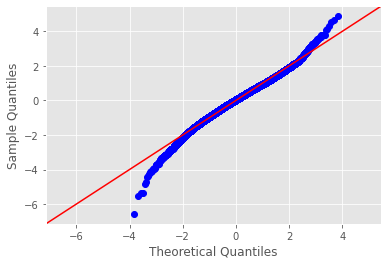

In [34]:
# Q-Q Plot to check normality of residuals
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

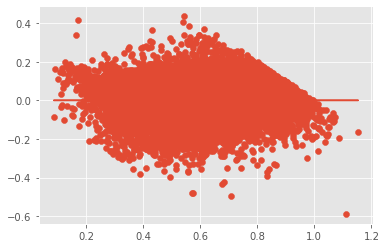

In [35]:
# Checking for Homoscedasticity
plt.scatter(model.predict(df[x_cols]), model.resid)
plt.plot(model.predict(df[x_cols]), [0 for i in range(len(df))])

## Model Refinement 3
Improve residual normality and heteroscedasticity

In [36]:
# Finding a cutoff point to narrow the price range
xmin=11.561716
xmax=13.835313

for i in range(0, 25, 1):
    q = i / 100
    price = np.exp(df['price']*(xmax-xmin)+xmin)  # get back to meaningful values - unstandardize
    print('{} percentile: {}'.format(q, price.quantile(q=q)))

print('---')
    
for i in range(75, 101, 1):
    q = i / 100
    price = np.exp(df['price']*(xmax-xmin)+xmin)  # get back to meaningful values - unstandardize
    print('{} percentile: {}'.format(q, price.quantile(q=q)))

0.0 percentile: 105000.03894034293
0.01 percentile: 156848.4227721934
0.02 percentile: 175000.04303472006
0.03 percentile: 190000.04290148403
0.04 percentile: 200000.0426501934
0.05 percentile: 208955.04232114536
0.06 percentile: 215000.04204569408
0.07 percentile: 222000.0416748515
0.08 percentile: 229000.04125001185
0.09 percentile: 234753.04086157965
0.1 percentile: 240000.04047724814
0.11 percentile: 245000.040084874
0.12 percentile: 250000.0396675398
0.13 percentile: 253000.03940536638
0.14 percentile: 258000.03894912492
0.15 percentile: 262500.03851822816
0.16 percentile: 267000.038068462
0.17 percentile: 270000.0377582919
0.18 percentile: 275000.037223267
0.19 percentile: 280000.0366660045
0.2 percentile: 285000.0360869022
0.21 percentile: 289950.0354924526
0.22 percentile: 294950.03487101494
0.23 percentile: 299900.03423536656
0.24 percentile: 301500.0340256149
---
0.75 percentile: 564999.9769662684
0.76 percentile: 574999.9740910776
0.77 percentile: 579999.9726374826
0.78 perc

In [37]:
# Keep values between 1% and 80%
lower = df['price'].quantile(q=.03)
upper = df['price'].quantile(q=.9)

subset = df[(df['price'] >= lower) & (df['price'] <= upper)].reset_index()
print('Percent removed:',(len(df) - len(subset))/len(df))

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=subset).fit()
model.summary()

Percent removed: 0.1272993949764713


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     676.6
Date:                Sat, 26 Dec 2020   Prob (F-statistic):               0.00
Time:                        19:17:05   Log-Likelihood:                 15791.
No. Observations:               14280   AIC:                        -3.148e+04
Df Residuals:                   14228   BIC:                        -3.109e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5044      0.019     26.269      0.000       0.467       0.542
sqft_living         0.1868      0.009     19.782      0.000       0.168       0.205
sqft_lot           -0.0296      0.007     -4.462      0.000      -0.043      -0.017
sqft_above          0.1068      0.009     11.661      0.000       0.089       0.125
yr_built           -0.0892      0.005    -18.265      0.000      -0.099      -0.080
yr_renovated        0.0142      0.005      2.979      0.003       0.005       0.024
lat                 0.2272      0.003     76.626      0.000       0.221       0.233
long               -0.1554      0.005    -30.330      0.000      -0.165      -0.145
sqft_living15       0.1534      0.007     22.601      0.000       0.140       0.167
sqft_lot15         -0.0180      0.008     -2.145      0.032      -0.034      -0.002
dist_2_downtown    -0.3392      0.007    -50.108      0.000      -0.352      -0.326
waterfront_1_0      0.2147      0.038      5.598      0.000       0.140       0.290
view_1_0            0.0578      0.007      8.752      0.000       0.045       0.071
view_2_0            0.0367      0.004      8.713      0.000       0.028       0.045
view_3_0            0.0497      0.007      6.758      0.000       0.035       0.064
view_4_0            0.1124      0.020      5.742      0.000       0.074       0.151
condition_3         0.0218      0.009      2.434      0.015       0.004       0.039
condition_4         0.0471      0.009      5.233      0.000       0.029       0.065
condition_5         0.0630      0.009      6.814      0.000       0.045       0.081
grade_7             0.0568      0.003     22.301      0.000       0.052       0.062
grade_8             0.1091      0.003     34.342      0.000       0.103       0.115
grade_9             0.1533      0.004     35.320      0.000       0.145       0.162
grade_10            0.1959      0.009     22.934      0.000       0.179       0.213
grade_11            0.1802      0.080      2.242      0.025       0.023       0.338
bedrooms_3         -0.0114      0.002     -5.047      0.000      -0.016      -0.007
bedrooms_4         -0.0138      0.003     -4.988      0.000      -0.019      -0.008
bedrooms_5         -0.0312      0.004     -7.576      0.000      -0.039      -0.023
floors_2_0         -0.0112      0.003     -4.363      0.000      -0.016      -0.006
floors_3_0         -0.0109      0.005     -2.191      0.028      -0.021      -0.001
bathrooms_1_0       0.0204      0.015      1.356      0.175      -0.009       0.050
bathrooms_1_5       0.0163      0.015      1.075      0.282      -0.013       0.046
bathrooms_1_75      0.0348      0.015      2.306      0.021       0.005       0.064
bathrooms_2_0       0.0317      0.015      2.090      0.037       0.002       0.061
bathrooms_2_25      0.0385      0.015      2.526      0.012

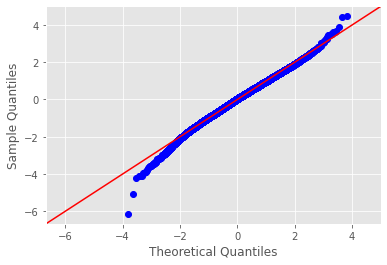

In [38]:
# Check Q-Q again
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

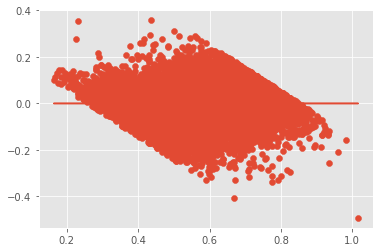

In [39]:
# Check heteroscedasticity again
plt.scatter(model.predict(subset[x_cols]), model.resid)
plt.plot(model.predict(subset[x_cols]), [0 for i in range(len(subset))])

## Test/train

In [40]:
# train test
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

In [41]:
# split data into train and test sets
train, test = train_test_split(subset)
print(len(train), len(test))

10710 3570


In [42]:
# Fitting the model to train data
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     513.9
Date:                Sat, 26 Dec 2020   Prob (F-statistic):               0.00
Time:                        19:17:07   Log-Likelihood:                 11844.
No. Observations:               10710   AIC:                        -2.359e+04
Df Residuals:                   10659   BIC:                        -2.321e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4972      0.022     22.114      0.000       0.453       0.541
sqft_living         0.1789      0.011     16.381      0.000       0.157       0.200
sqft_lot           -0.0307      0.008     -3.999      0.000      -0.046      -0.016
sqft_above          0.1059      0.011      9.976      0.000       0.085       0.127
yr_built           -0.0865      0.006    -15.298      0.000      -0.098      -0.075
yr_renovated        0.0241      0.006      4.279      0.000       0.013       0.035
lat                 0.2252      0.003     65.959      0.000       0.218       0.232
long               -0.1527      0.006    -25.840      0.000      -0.164      -0.141
sqft_living15       0.1621      0.008     20.814      0.000       0.147       0.177
sqft_lot15         -0.0201      0.010     -2.079      0.038      -0.039      -0.001
dist_2_downtown    -0.3435      0.008    -44.204      0.000      -0.359      -0.328
waterfront_1_0      0.2059      0.046      4.481      0.000       0.116       0.296
view_1_0            0.0611      0.008      7.995      0.000       0.046       0.076
view_2_0            0.0366      0.005      7.667      0.000       0.027       0.046
view_3_0            0.0514      0.009      5.972      0.000       0.035       0.068
view_4_0            0.1085      0.022      5.018      0.000       0.066       0.151
condition_3         0.0216      0.011      2.029      0.042       0.001       0.043
condition_4         0.0479      0.011      4.479      0.000       0.027       0.069
condition_5         0.0629      0.011      5.730      0.000       0.041       0.084
grade_7             0.0546      0.003     18.509      0.000       0.049       0.060
grade_8             0.1069      0.004     29.062      0.000       0.100       0.114
grade_9             0.1497      0.005     29.683      0.000       0.140       0.160
grade_10            0.1964      0.010     19.583      0.000       0.177       0.216
grade_11         4.464e-16   9.57e-17      4.665      0.000    2.59e-16    6.34e-16
bedrooms_3         -0.0123      0.003     -4.700      0.000      -0.017      -0.007
bedrooms_4         -0.0135      0.003     -4.197      0.000      -0.020      -0.007
bedrooms_5         -0.0299      0.005     -6.335      0.000      -0.039      -0.021
floors_2_0         -0.0125      0.003     -4.182      0.000      -0.018      -0.007
floors_3_0         -0.0162      0.006     -2.823      0.005      -0.028      -0.005
bathrooms_1_0       0.0287      0.018      1.619      0.105      -0.006       0.063
bathrooms_1_5       0.0271      0.018      1.516      0.130      -0.008       0.062
bathrooms_1_75      0.0446      0.018      2.504      0.012       0.010       0.080
bathrooms_2_0       0.0426      0.018      2.383      0.017       0.008       0.078
bathrooms_2_25      0.0482      0.018      2.683      0.007

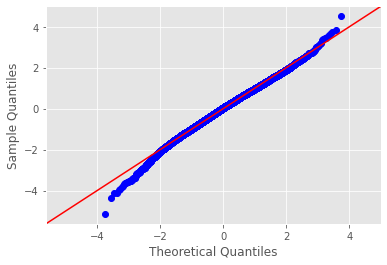

In [43]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

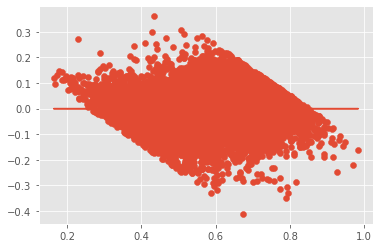

In [44]:
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

In [45]:
# Most significant features
coeffs = pd.DataFrame(model.params, columns=['coeffs'])
coeffs['abs'] = coeffs.abs()
coeffs = coeffs.sort_values('abs', ascending=False)
coeffs.head(10)

,coeffs,abs
Intercept,0.497250,0.497250
dist_2_downtown,-0.343534,0.343534
lat,0.225159,0.225159
waterfront_1_0,0.205905,0.205905
grade_10,0.196366,0.196366
sqft_living,0.178862,0.178862
sqft_living15,0.162060,0.162060
long,-0.152748,0.152748
grade_9,0.149680,0.149680
view_4_0,0.108460,0.108460


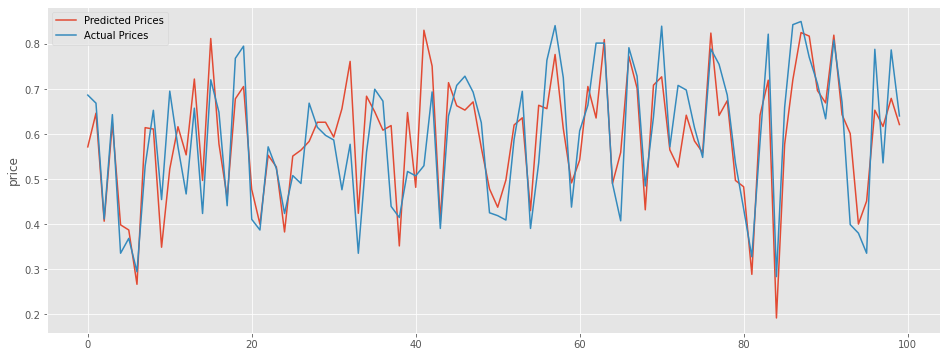

In [46]:
# Use the test set to see how the train set did
X = test[x_cols].sort_index()
ypred = model.predict(X)
bot = 1100
top = 1200

x = range(top-bot)
ypred = ypred[bot:top]
yactual = test['price'].sort_index()[bot:top]

plt.figure(figsize=(16,6))
sns.lineplot(x=x, y=ypred, label='Predicted Prices')
sns.lineplot(x=x, y=yactual, label='Actual Prices')
plt.show()

In [47]:
print('R^2 Score:',round(model.rsquared, 5))
print('Average Predicted Price:', round(ypred.mean(),4))
print('Average Actual Price:', round(yactual.mean(), 4))

R^2 Score: 0.70681
Average Predicted Price: 0.5905
Average Actual Price: 0.5886


## Model Evaluation

In [48]:
# function to take a random property and make a graph by adjusting a selected feature
def predict_feat(feat, maxfeat, minfeat, title):
    df_copy = df_b4_scale[(df_b4_scale[feat]<=maxfeat) & (df_b4_scale[feat]>=minfeat)]
    i = int(len(df_copy)/2) # take a house from middle of set
    df_dist = pd.DataFrame(df_copy.iloc[i]).transpose()
    step = minfeat

    for row in range(1,11):
        df_dist = df_dist.append(df_copy.iloc[i].transpose(), ignore_index=True)
        df_dist[feat][row] = step 
        step += (maxfeat - minfeat)/10
    actual_feat = df_dist[feat][0]
    actual_price = df_dist['price'][0]
                 
    df_dist['long'] = df_dist['long']*-1
                 
    for feat3 in feats_4_log:
        df_dist[feat3] = np.log(df_dist[feat3])

    for feat2 in list(df_dist.columns):
        if feat2 == 'long':
            featmax = max(np.log(df_b4_scale[feat2]*-1))
            featmin = min(np.log(df_b4_scale[feat2]*-1))
            df_dist[feat2] = (df_dist[feat2] - featmin) / (featmax - featmin)
            continue
        if feat2 in feats_4_log:
            featmax = max(np.log(df_b4_scale[feat2]))
            featmin = min(np.log(df_b4_scale[feat2]))
            df_dist[feat2] = (df_dist[feat2] - featmin) / (featmax - featmin)
            continue
        else:
            featmax = max(df_b4_scale[feat2])
            featmin = min(df_b4_scale[feat2])
            df_dist[feat2] = (df_dist[feat2] - featmin) / (featmax - featmin)
            
    maxprice = 13.835313
    minprice = 11.561716
    maxfeat = max(np.log(df_b4_scale[feat]))
    minfeat = min(np.log(df_b4_scale[feat]))
    
    x=np.exp(df_dist[feat] * (maxfeat-minfeat) + minfeat)
    ypred_feat = model.predict(df_dist)
    ypred_feat = np.exp(ypred_feat * (maxprice-minprice) + minprice)
    print('Actual Price: ${}, Actual Feat: {}.'.format(int(actual_price), actual_feat))
    plt.figure(figsize=(6,4))
    plt.title(('{} v. Price').format(title))
    sns.lineplot(x=x, y=ypred_feat, label='Predicted Prices', markers=True)
    return (x, ypred_feat)

Actual Price: $318000, Actual Feat: 12.074.


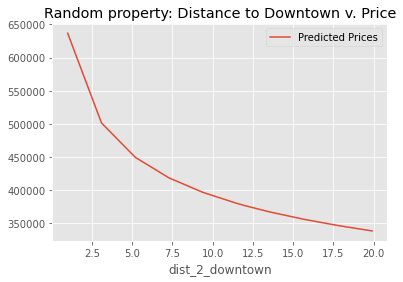

In [49]:
x_dists, prices_v_dists = predict_feat('dist_2_downtown', 22, 1, 'Random property: Distance to Downtown')

In [50]:
x_dists

0     12.074
1      1.000
2      3.100
3      5.200
4      7.300
5      9.400
6     11.500
7     13.600
8     15.700
9     17.800
10    19.900
Name: dist_2_downtown, dtype: float64

In [51]:
prices_v_dists

0     376463.558048
1     636670.208638
2     501502.493816
3     449666.066366
4     418616.610001
5     396876.717628
6     380351.164740
7     367130.617693
8     356177.960191
9     346870.391405
10    338806.231080
dtype: float64

Actual Price: $291000, Actual Feat: 47.3768.


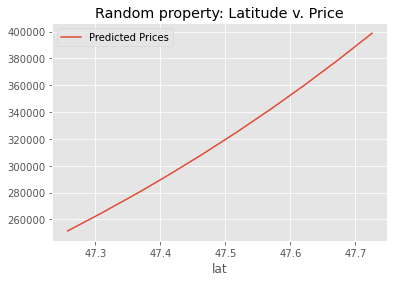

In [52]:
current_feat = 'lat'
x_lat, prices_v_lat = predict_feat(current_feat, max(df_b4_scale[current_feat]), 
                                   min(df_b4_scale[current_feat]), 'Random property: Latitude')

In [53]:
print(x_lat)
print(prices_v_lat)

0     47.37680
1     47.25740
2     47.30942
3     47.36144
4     47.41346
5     47.46548
6     47.51750
7     47.56952
8     47.62154
9     47.67356
10    47.72558
Name: lat, dtype: float64
0     282972.333273
1     251477.391731
2     264753.187261
3     278714.070203
4     293394.582628
5     308830.967395
6     325061.249899
7     342125.323634
8     360065.039778
9     378924.300956
10    398749.159394
dtype: float64


Actual Price: $295832, Actual Feat: 1410.0.


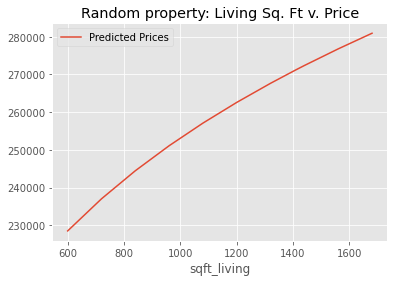

In [54]:
x_sgft, prices_v_sgft = predict_feat('sqft_living', 1800, 600, 'Random property: Living Sq. Ft')

Actual Price: $281000, Actual Feat: 1020.0.


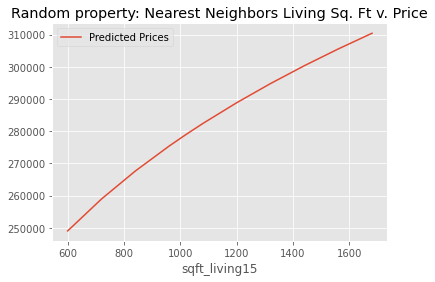

In [55]:
x_sgft15, prices_v_sgft15 = predict_feat('sqft_living15', 1800, 600, 'Random property: Nearest Neighbors Living Sq. Ft')

In [56]:
def predict_categorical(feat, pricemax, pricemin, feat_true, title):
    df_copy = df_b4_scale[(df_b4_scale[feat]==feat_true) &(df_b4_scale['price']<=pricemax) & (df_b4_scale['price']>=pricemin)]
    i = int(len(df_copy)/2) # take a house from middle of set
    
    df_cat = pd.DataFrame(df_copy.iloc[i]).transpose()
    df_cat = df_cat.append(df_copy.iloc[i].transpose(), ignore_index=True)
    df_cat[feat][1] = (df_cat[feat][0] - 1)*-1
    
    actual_feat = df_cat[feat][0]
    actual_price = df_cat['price'][0]
                 
    df_cat['long'] = df_cat['long']*-1
                 
    for feat3 in feats_4_log:
        df_cat[feat3] = np.log(df_cat[feat3])

    for feat2 in list(df_cat.columns):
        if feat2 == 'long':
            featmax = max(np.log(df_b4_scale[feat2]*-1))
            featmin = min(np.log(df_b4_scale[feat2]*-1))
            df_cat[feat2] = (df_cat[feat2] - featmin) / (featmax - featmin)
            continue
        if feat2 in feats_4_log:
            featmax = max(np.log(df_b4_scale[feat2]))
            featmin = min(np.log(df_b4_scale[feat2]))
            df_cat[feat2] = (df_cat[feat2] - featmin) / (featmax - featmin)
            continue
        else:
            featmax = max(df_b4_scale[feat2])
            featmin = min(df_b4_scale[feat2])
            df_cat[feat2] = (df_cat[feat2] - featmin) / (featmax - featmin)
            
    maxprice = 13.835313
    minprice = 11.561716
    maxfeat = 0
    minfeat = 1
    
    x=[df_cat[feat][0], df_cat[feat][1]]
    ypred_feat = model.predict(df_cat)
    ypred_feat = np.exp(ypred_feat * (maxprice-minprice) + minprice)
    print('Actual Price: ${}, Actual Feat: {}.'.format(int(actual_price), actual_feat))
    plt.figure(figsize=(6,4))
    g=sns.lineplot(x=x, y=ypred_feat, label='Predicted Prices')
    g.set_xticks([0,1])
    plt.title(('{} v. Price').format(title))
#     plt.show()
    return (x, ypred_feat)

Actual Price: $443000, Actual Feat: 0.0.
Actual Price: $520000, Actual Feat: 1.0.


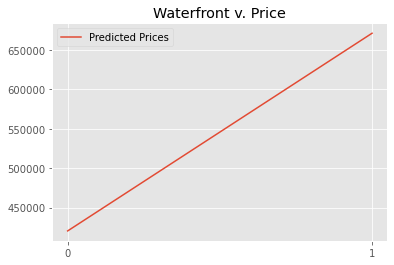

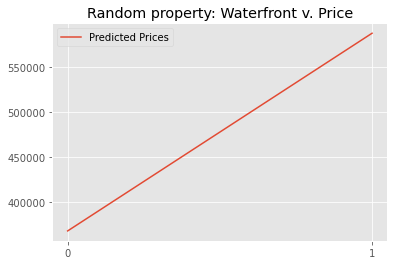

In [57]:
x_water1, y_water1 = predict_categorical('waterfront_1_0', 5*10**5, 2*10**5, 0, 'Waterfront')
x_water2, y_water2 = predict_categorical('waterfront_1_0', 5.5*10**5, 2*10**5, 1, 'Random property: Waterfront')

In [58]:
print(y_water1)
print(y_water2)

0    420299.776075
1    671231.313808
dtype: float64
0    588071.760047
1    368228.394563
dtype: float64


Actual Price: $965000, Actual Feat: 1.0.
Actual Price: $746500, Actual Feat: 1.0.
Actual Price: $600000, Actual Feat: 1.0.


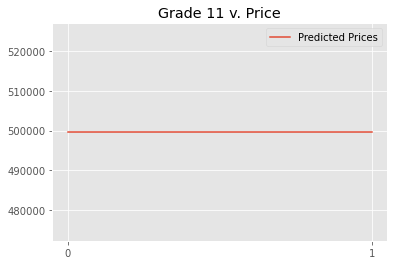

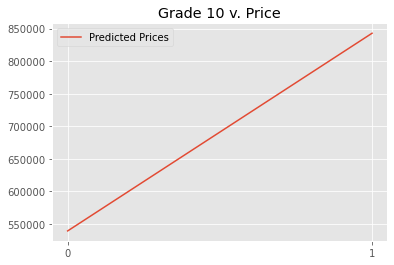

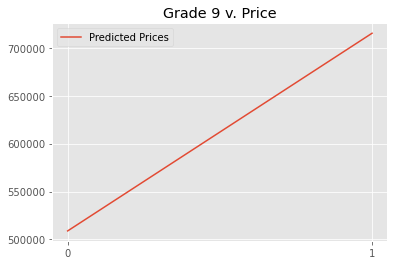

In [59]:
x_g11, y_g11 = predict_categorical('grade_11', 1*10**6, 2*10**5, 1, 'Grade 11')
x_g10, y_g10 = predict_categorical('grade_10', 1*10**6, 2*10**5, 1, 'Grade 10')
x_g9, y_g9 = predict_categorical('grade_9', 1*10**6, 2*10**5, 1, 'Grade 9')

In [60]:
# create additional graphics
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
import geopandas as gpd # To create GeodataFram
import pandas as pd
from pyproj import CRS
import matplotlib.pyplot as plt

In [61]:
def add_geo_col(df):
    # create a geometry column 
    geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]

    # Coordinate reference system : WGS84 (the GPS model for conversion)
    crs = CRS('epsg:4326')

    # Creating a Geographic data frame 
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry).reset_index()
    return gdf

In [62]:
gdf2 = pd.read_pickle('data/geodata.pkl')

In [63]:
df_top10_employers = pd.read_csv('data/top_employers.csv')
df3 = df_top10_employers[df_top10_employers['centralized_campus']=='y'].reset_index()
gdf3 = add_geo_col(df3)

In [64]:
downtown = Point(-122.3244, 47.6150)
gdf4 = gpd.GeoSeries(downtown, crs=4326)

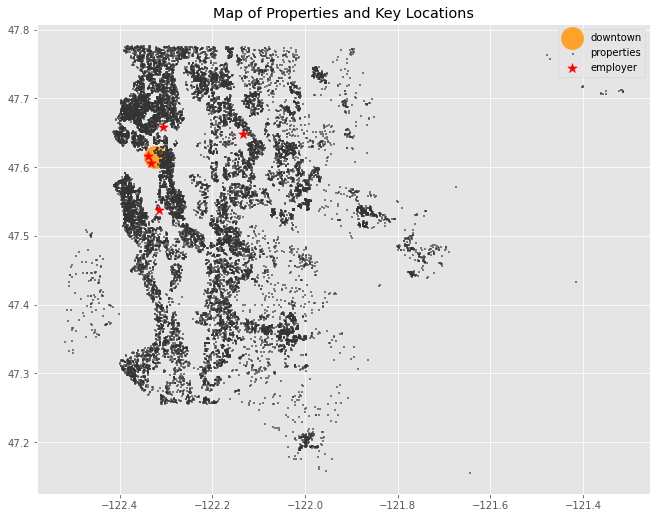

In [65]:
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True, figsize=(11, 20))
gdf4.plot(ax=ax, marker='o', color='#FFA12A', markersize=500, label='downtown')
gdf2.plot(ax=ax, marker='s', color='#333333', markersize=1, label='properties')
gdf3.plot(ax=ax, marker='*', color='r', markersize=100, label='employer')
ax.title.set_text('Map of Properties and Key Locations')
ax.legend()